In [1]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import numpy as np
import pandas as pd 
import xarray as xr
import geopandas as gpd 
from shapely import box

import config.settings as cset

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            )

from tqdm.notebook import tqdm

In [8]:
thrshld = 1.35
thrshld_str = '135'
# loading & preparing glmt data 
gmt_char_df = pd.read_csv(cset.path_MESMER_char / f'gmt_characteristics_thsld_{thrshld_str}.csv', index_col = 0)

In [3]:
peak_gdp_impacts = [pd.read_csv(cset.path_OUT_PW / file) for file in cset.PW_dataset_names]

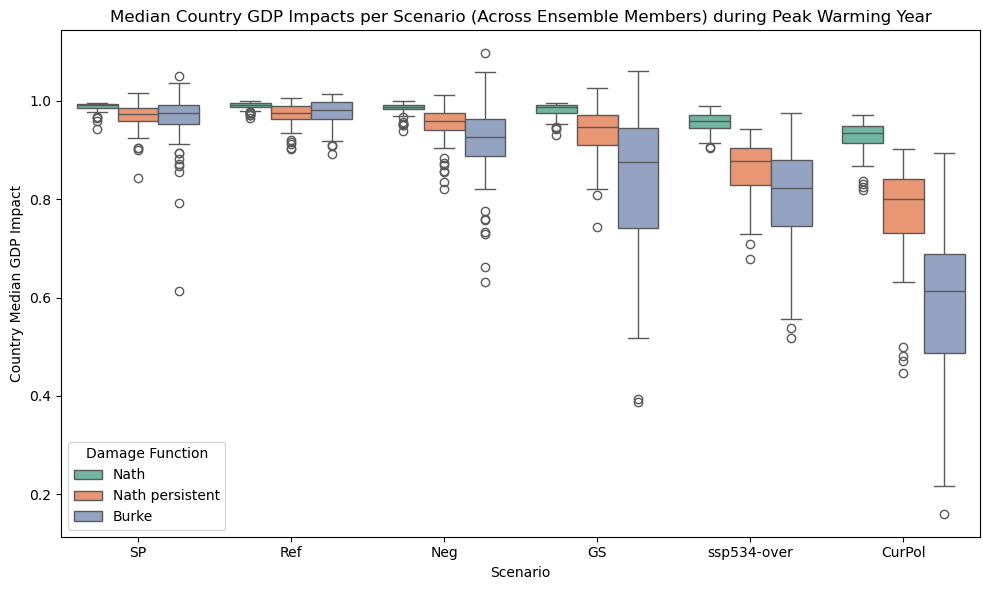

In [5]:
# Function to extract per-ensemble-member country median for each scenario group
def get_ensemble_medians(df, dataset_label):
    rows = []
    for scenario_prefix in cset.focus_scenarios:  # Add more as needed
        scenario_cols = [col for col in df.columns if col.startswith(scenario_prefix)]
        for col in scenario_cols:
            country_median = df[col].median()
            rows.append({
                'Scenario': scenario_prefix,
                'EnsembleMember': col,
                'MedianValue': country_median,
                'Dataset': dataset_label
            })
    return pd.DataFrame(rows)

# Combine medians for all datasets
ensemble_medians_df = pd.concat([
    get_ensemble_medians(df, f'{cset.GDP_labels[i]}')
    for i, df in enumerate(peak_gdp_impacts)
])

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=ensemble_medians_df,
    x='Scenario',
    y='MedianValue',
    hue='Dataset',
    palette='Set2'
)
plt.title('Median Country GDP Impacts per Scenario (Across Ensemble Members) during Peak Warming Year')
plt.ylabel('Country Median GDP Impact')
plt.xlabel('Scenario')
plt.legend(title='Damage Function')
plt.tight_layout()
plt.show()

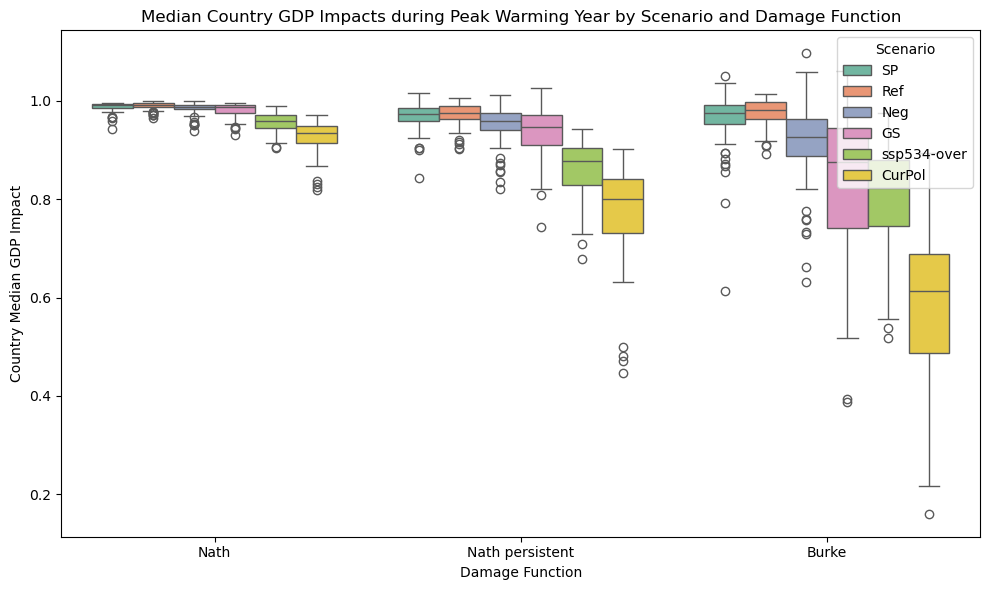

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=ensemble_medians_df,
    x='Dataset',                 # Damage function on x-axis
    y='MedianValue',
    hue='Scenario',              # Group by scenario within each DF
    palette='Set2'
)

plt.title('Median Country GDP Impacts during Peak Warming Year by Scenario and Damage Function')
plt.ylabel('Country Median GDP Impact')
plt.xlabel('Damage Function')
plt.legend(title='Scenario', loc='upper right')
plt.tight_layout()
plt.show()


In [9]:
# plotting mean warming between 2015-2030 against median GDP impacts dring peak warming year 
ensemble_medians_df['gmt_ntwr'] = gmt_char_df.loc[ensemble_medians_df.EnsembleMember.values, 'gmt_ntwr'].values

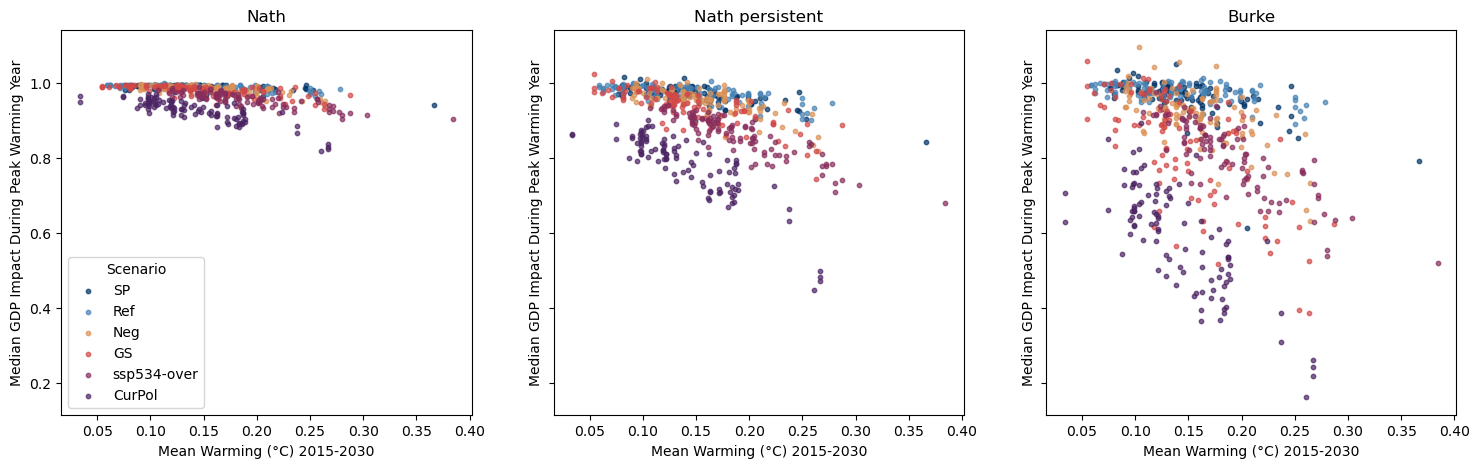

In [10]:
fig, axes  = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5), sharey = True)
for i, dataset in enumerate(cset.GDP_labels):
    subset = ensemble_medians_df[ensemble_medians_df['Dataset'] == dataset]
    for scenario in cset.focus_scenarios:
        scenario_subset = subset[subset['Scenario'] == scenario]
        color = cset.focus_scenarios_color_dict[scenario]
        axes[i].scatter(scenario_subset['gmt_ntwr'], scenario_subset['MedianValue'], s=10, color = color, alpha=0.7, label = scenario)
    if i == 0:
        axes[i].legend(title='Scenario', loc='lower left')
    axes[i].set_xlabel('Mean Warming (°C) 2015-2030')
    axes[i].set_ylabel('Median GDP Impact During Peak Warming Year')
    axes[i].set_title(f'{dataset}')
plt.show()

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_21971/867844359.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


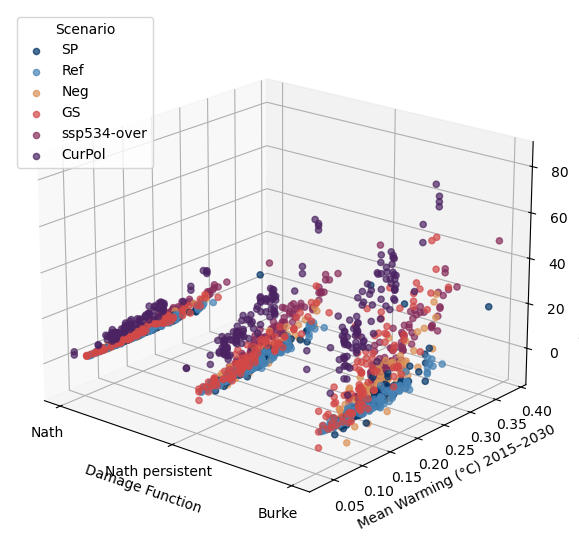

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Prepare the 3D figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Map dataset names to damage function index
damage_fn_map = {label: i for i, label in enumerate(cset.GDP_labels)}

# Marker and color settings
colors = cset.focus_scenarios_color_dict
scenarios = cset.focus_scenarios

for scenario in scenarios:
    for dataset in cset.GDP_labels:
        x = damage_fn_map[dataset]
        scenario_subset = ensemble_medians_df[
            (ensemble_medians_df['Dataset'] == dataset) &
            (ensemble_medians_df['Scenario'] == scenario)
        ]
        y_vals = scenario_subset['gmt_ntwr']
        z_vals = (1 - scenario_subset['MedianValue']) * 100  # GDP loss in %

        ax.scatter(
            [x]*len(y_vals),  # X = damage function index
            y_vals,           # Y = gmt_ntwr
            z_vals,           # Z = GDP loss in %
            color=colors[scenario],
            alpha=0.7,
            label=scenario if dataset == cset.GDP_labels[0] else "",
            s=20
        )

# Axes labels
ax.set_xlabel('Damage Function')
ax.set_ylabel('Mean Warming (°C) 2015–2030')
ax.set_zlabel('Median GDP Loss at Peak (%)')

# Set tick labels for damage function
ax.set_xticks(range(len(cset.GDP_labels)))
ax.set_xticklabels(cset.GDP_labels)

# Legend
ax.legend(title='Scenario', loc='upper left')

ax.view_init(elev=20, azim=-50)  # Adjust azim from -60 to -50
plt.tight_layout()
plt.show()

